## Denoising Diffusion Implicit Models - DDIMNote, this notebook is explained in Lesson 21 

Note, this notebook is explained in Lesson 21.  The DDIM topic is reached after about an hour

### Imports and setup 

In [1]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.fid import *

In [2]:
from fastprogress.fastprogress import progress_bar

In [3]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)
if fc.defaults.cpus>8: fc.defaults.cpus=7

mdl_path = Path('/home/models')

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

In [6]:
class UNet(UNet2DModel): pass

Although the model below was trained using a different scheduler, it is possible to run it with different schedulers (afterall they simply control the values of t passed to the model 

In [7]:
model = torch.load(mdl_path/'fashion_ddpm3_25.pkl').cuda()

In [8]:
#Create a huggingface scheduler
sched = DDPMScheduler(beta_end=0.01)

In [11]:
# Create a matrix of images containing random noise
x_t = torch.randn((32,1,32,32)).cuda()

In [12]:
# Implement the first step and predict the noise beleived to be in the image
t = 999
t_batch = torch.full((len(x_t),), t, device=x_t.device, dtype=torch.long)
with torch.no_grad(): noise = model(x_t, t_batch).sample    

In [13]:
# Implement the step with the scheduler.  This subtracts a portion of the noise predicted
# from the supplied image
res = sched.step(noise, t, x_t)

In [15]:
# prev_sample is the image generated an the next value of t (which is lower and hence prev)
res.prev_sample.shape

torch.Size([32, 1, 32, 32])

Having checked the process works inplement in a loop

In [14]:
# Define the size of the array to generate, which is how many images and the size of each.  
# In this case 2048 images are being generated which gives a fairly stable FID value
sz = (2048,1,32,32)

In [17]:
%%time
x_t = torch.randn(sz).cuda()
preds = []

for t in progress_bar(sched.timesteps):
    with torch.no_grad(): noise = model(x_t, t).sample
    x_t = sched.step(noise, t, x_t).prev_sample
    preds.append(x_t.float().cpu())

CPU times: user 16min 1s, sys: 4.08 s, total: 16min 5s
Wall time: 16min 4s


In [20]:
s = preds[-1].clamp(-0.5,0.5)*2

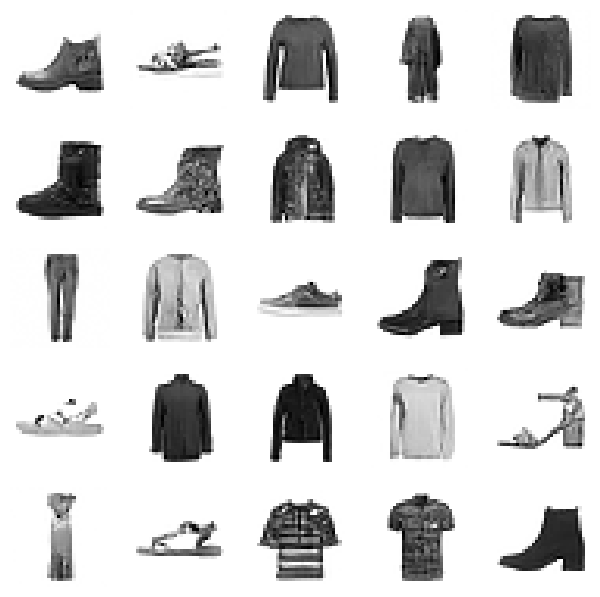

In [21]:
show_images(s[:25], imsize=1.5)

Load the classifier and remove the last two layers to enable it to be used for FID

In [9]:
cmodel = torch.load(mdl_path / 'data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

In [10]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

bs = 2048
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb,yb = next(iter(dt))

ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])

In [24]:
ie.fid(s),ie.kid(s)

(3.1070556640625, 0.0045813932083547115)

In [25]:
ie.fid(xb),ie.kid(xb)

(0.64642333984375, 0.004615178797394037)

### Diffusers DDIM Scheduler

In [11]:
# Create a DDIM scheduler and set it to only use 333 steps
sched = DDIMScheduler(beta_end=0.01)
sched.set_timesteps(333)

In [12]:
def diff_sample(model, sz, sched, **kwargs):
    x_t = torch.randn(sz).cuda()
    preds = []
    for t in progress_bar(sched.timesteps):
        with torch.no_grad(): noise = model(x_t, t).sample
        x_t = sched.step(noise, t, x_t, **kwargs).prev_sample
        preds.append(x_t.float().cpu())
    return preds

In [28]:
# eta is the proportaion of the noise to add
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1,1)

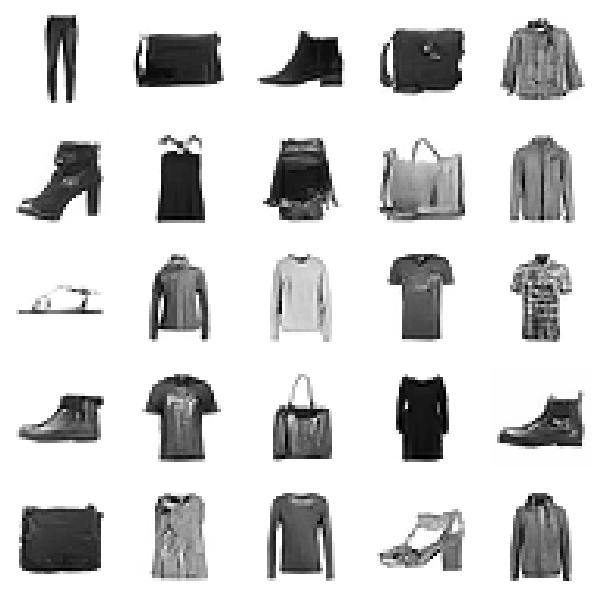

In [29]:
show_images(s[:25], imsize=1.5)

In [30]:
ie.fid(s),ie.kid(s)

(4.0418701171875, 0.009043844416737556)

Now try with 200 steps

In [31]:
sched.set_timesteps(200)
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1,1)
ie.fid(s),ie.kid(s)

(5.2879638671875, 0.01477047335356474)

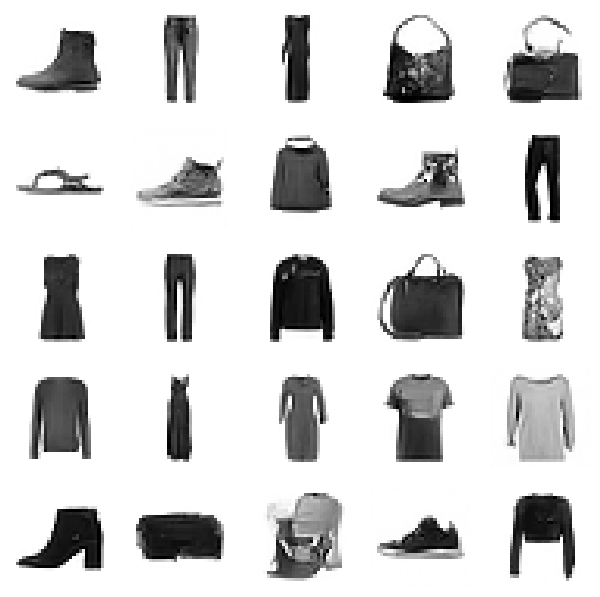

In [32]:
show_images(s[:25], imsize=1.5)

In [15]:
sched.set_timesteps(100)
preds = diff_sample(model, sz, sched, eta=1.)

In [16]:
s = (preds[-1]*2).clamp(-1,1)

In [17]:
ie.fid(s),ie.kid(s)

(9.69366455078125, 0.05819448456168175)

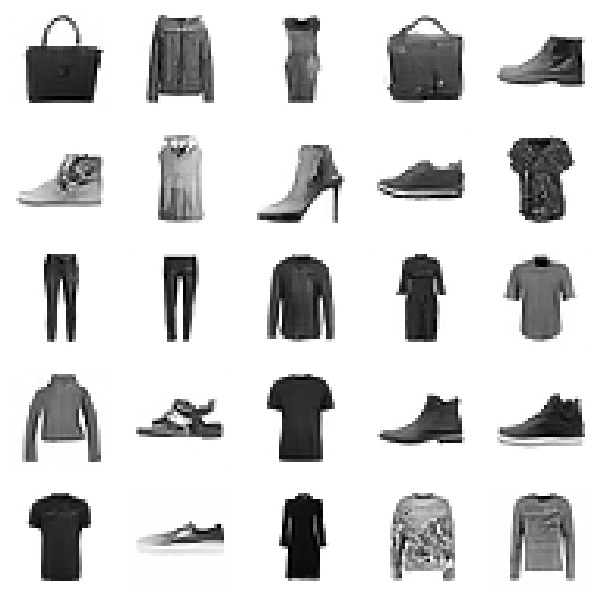

In [18]:
show_images(s[:25], imsize=1.5)

In [19]:
sched.set_timesteps(50)
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1,1)
ie.fid(s),ie.kid(s)
     

(16.09130859375, 0.09669212996959686)

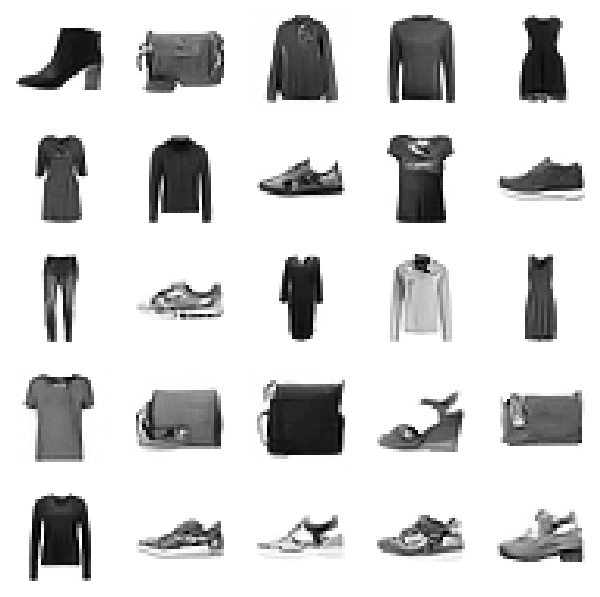

In [20]:
show_images(s[:25], imsize=1.5)

In [21]:
sched.set_timesteps(25)
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1,1)
ie.fid(s),ie.kid(s)

(27.95709228515625, 0.15559417009353638)

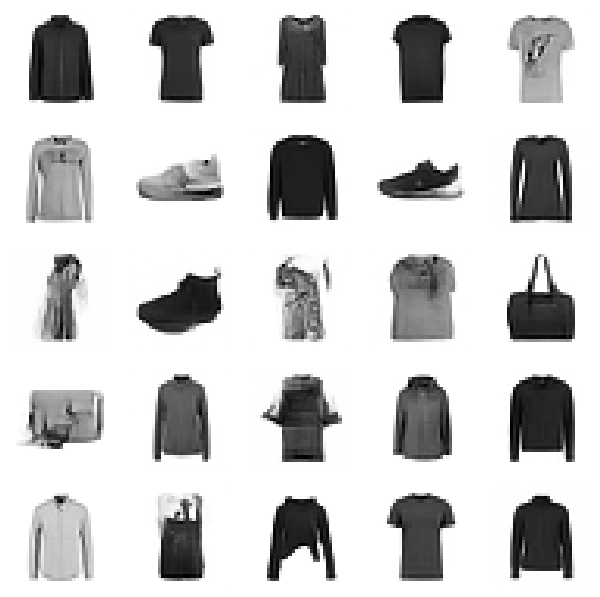

In [22]:
show_images(s[:25], imsize=1.5)

## Imlementing DDIM 

In [24]:
from types import SimpleNamespace

In [25]:
n_steps=1000

Note that in this figure the nomenclature is different to that in the DDPM paper:
$$\alpha = \bar{\alpha}$$
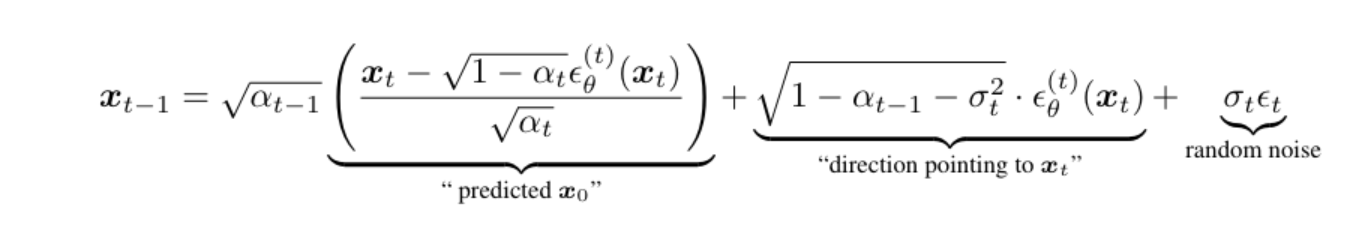

Note that in the above equation the $(x_t)$ term is not used in the code, need to understand why 

In [26]:
# Create a simple linear scheduler
def linear_sched(betamin=0.0001,betamax=0.02,n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())

In [27]:
sc = linear_sched(betamax=0.01, n_steps=n_steps)
abar = sc.abar

In [28]:
def ddim_step(x_t, t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta):
    """ Function to implement the DDIM step as per the above equation
    """
    vari = ((bbar_t1/bbar_t) * (1-abar_t/abar_t1))
    sig = vari.sqrt()*eta
    x_0_hat = ((x_t-bbar_t.sqrt()*noise) / abar_t.sqrt())
    x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
    if t>0: x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_t